In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0.5, 0, 'Date')

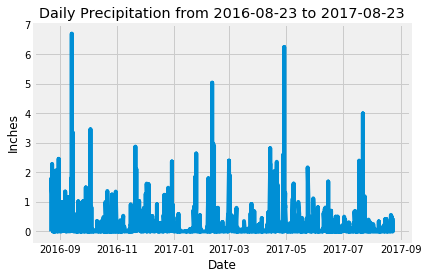

In [195]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
#columns = inspector.get_columns("Measurement")
#print("Inspect: Measurement")
#print()
#for column in columns:
#    print(column["name"], column["type"])

# Calculate the date 1 year ago from the last data point in the database
lastdate = dt.date.fromisoformat((session.query(func.max(Measurement.date)).all()[0][0]))
lastdate12 = dt.date(lastdate.year - 1, lastdate.month, lastdate.day)

# Above works, but needs to be formatted as an ORM query
ORMquery = session\
           .query(Measurement.date, Measurement.prcp)\
           .filter(Measurement.date >= lastdate12)\
           .all()

myQuerydf = pd\
            .DataFrame(index=[index for index, value in enumerate(ORMquery)],
                         data={'date': [query[0] for query in ORMquery],
                               'prcp': [query[1] for query in ORMquery]})
    
myQuerydf["date_adj"] = pd.to_datetime(myQuerydf["date"])

myQuerydf = myQuerydf\
            .dropna()\
            .sort_values('date_adj')\
            .set_index('date_adj')

plt.plot(myQuerydf.index, myQuerydf.prcp)
plt.title(f"Daily Precipitation from {lastdate12} to {lastdate}")
plt.ylabel("Inches")
plt.xlabel("Date")

![precipitation](Images/precipitation.png)

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
myQuerydf.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [91]:
# Design a query to show how many stations are available in this dataset?

stnCt = session\
        .query(Station.name)\
        .distinct()\
        .count()

from sqlalchemy import distinct
stnCt2 = session.query(func.count(distinct(Station.name)))
        
print(f"There are a total of {stnCt} stations")


There are a total of 9 stations


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stnCtAll = session\
           .query(distinct(Station.name), func.count(distinct(Measurement.id)).label("activity"))\
           .join(Measurement, Measurement.station == Station.station)\
           .group_by(Station.name)\
           .order_by(func.count(distinct(Measurement.id)).desc())\
           .all()

for stn in stnCtAll:
    print (f"Station: {stn[0]}\nCount: {stn[1]}\n")

Station: WAIHEE 837.5, HI US
Count: 2772

Station: WAIKIKI 717.2, HI US
Count: 2724

Station: KANEOHE 838.1, HI US
Count: 2709

Station: WAIMANALO EXPERIMENTAL FARM, HI US
Count: 2669

Station: MANOA LYON ARBO 785.2, HI US
Count: 2612

Station: KUALOA RANCH HEADQUARTERS 886.9, HI US
Count: 2202

Station: HONOLULU OBSERVATORY 702.2, HI US
Count: 1979

Station: PEARL CITY, HI US
Count: 1372

Station: UPPER WAHIAWA 874.3, HI US
Count: 511



In [168]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stnCtSumAll = session\
              .query(distinct(Station.name),\
                     Station.station,
                     func.min(Measurement.tobs).label("Min"),
                     func.max(Measurement.tobs).label("Max"),
                     func.avg(Measurement.tobs).label("Average"))\
              .join(Measurement, Measurement.station == Station.station)\
              .group_by(Station.name)\
              .order_by(func.count(distinct(Measurement.id)).desc())\
              .first()

print("Summary")
print(f"Station: {stnCtSumAll[0]}")
print(f"Station ID: {stnCtSumAll[1]}")
print(f"Min temp: {stnCtSumAll[2]}")
print(f"Max temp: {stnCtSumAll[3]}")
print(f"Avg temp: {stnCtSumAll[4]}")


Summary
Station: WAIHEE 837.5, HI US
Station ID: USC00519281
Min temp: 54.0
Max temp: 85.0
Avg temp: 71.66378066378067


Text(0.5, 0, 'Temperature')

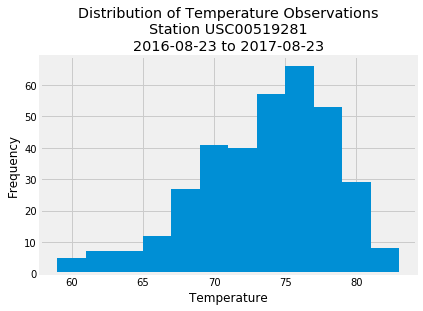

In [203]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

forhist     = session\
              .query(Measurement.date,
                     Measurement.tobs)\
              .filter(Measurement.station == stnCtSumAll[1])\
              .filter(Measurement.date >= lastdate12)\
              .all()

histdf    = pd\
            .DataFrame(index=[index for index, value in enumerate(forhist)],
                         data={'date': [query[0] for query in forhist],
                               'tobs': [query[1] for query in forhist]})
    
histdf["date_adj"] = pd.to_datetime(histdf["date"])

histdf = histdf\
            .dropna()\
            .sort_values('date_adj')\
            .set_index('date_adj')

plt.hist(histdf.tobs, bins=12, )
plt.title(f"Distribution of Temperature Observations\nStation {stnCtSumAll[1]}\n{lastdate12} to {lastdate}")
plt.ylabel("Frequency")
plt.xlabel("Temperature")


![precipitation](Images/station-histogram.png)

In [204]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [205]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [237]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ct = calc_temps('2016-08-23', '2017-08-23')[0]
# Close, but not quite
#plt.bar(1, ct[1])
#plt.errorbar(1, ct[1], ct[0], ct[2])

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
